In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

In [2]:
import pandas as pd, numpy as np, os, sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display, HTML

font = {'size'   : 18}
matplotlib.rc('font', **font)

def plotHorizontalBars(series, xlabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.barh(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='x')
    plt.yticks(xpos, series.index)
    plt.xlabel(xlabel)
    plt.title(title)

def plotVerticalBars(series, ylabel, title):
    xpos = np.arange(len(series.index), 0, -1)
    plt.bar(xpos, series, align='center', alpha=0.5, color='g')
    plt.grid(axis='y')
    plt.xticks(xpos, series.index)
    plt.ylabel(ylabel)
    plt.title(title)

In [3]:
import ssl, re
ssl._create_default_https_context = ssl._create_unverified_context
pd.__version__

'0.25.3'

In [6]:
# on Github, open CSV file and click on 'Raw'. Copy URL

filename = 'time_series_19-covid-Confirmed.csv'
data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'+filename
ts_df = pd.read_csv(data_url)
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Diamond Princess', x) is not None)]
ts_df = ts_df[~ts_df['Province/State'].astype(str).map(lambda x: re.search('Grand Princess', x) is not None)]
ts_df = ts_df.sort_values(['Country/Region', 'Province/State'])
print(ts_df['Country/Region'].unique())
display(ts_df)

HTTPError: HTTP Error 404: Not Found

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

lin_df = ts_df.drop(['Lat', 'Long', 'Province/State'], axis=1)
lin_df = lin_df.groupby('Country/Region').sum().transpose()
lin_df['date_count'] = [i for i in range(lin_df.shape[0])]
display(lin_df.tail(7))

In [ ]:
log_df = lin_df.copy()
log_df[log_df == 0] = 1e-5
log_df = np.log(log_df)
log_df[log_df < 0.1] = 0.0
log_df.date_count = lin_df.date_count
display(log_df.head(4))

In [ ]:
countries = ['Mainland China', 'US', 'Italy', 'Korea, South', 'Germany']
countries = ['US', 'Italy', 'Korea, South', 'Germany', 'France', 'Iran']
display(lin_df[['date_count'] + countries].tail(7))

fig, ax = plt.subplots(figsize=(15, 4))
for country in countries:
    ax.plot(log_df.date_count, log_df[country], label=country)
ax.legend(frameon=False, ncol=2, fontsize='x-small')

In [5]:
country = 'US'
us_df = lin_df[['date_count', country]]
mat = us_df.values.astype(np.int)
mat = mat[mat[:, 0] < 61]
mat = np.r_[mat,
            np.array([[61, 46100]]), # 3/23
            np.array([[62, 55100]])] # 3/24
us_df = pd.DataFrame(mat, columns=['date_count', country])
us_df = us_df[us_df.date_count >= 37]
log_us_df = np.c_[us_df.date_count.values, np.log(us_df[country])]
log_us_df = pd.DataFrame(log_us_df, columns=['date_count', country])
display(us_df.tail(10))

fig, ax = plt.subplots(figsize=(15, 4))
ax.plot(log_us_df['date_count'], log_us_df[country], label=country)
ax.legend(frameon=False, ncol=2, fontsize='x-small')

NameError: name 'lin_df' is not defined

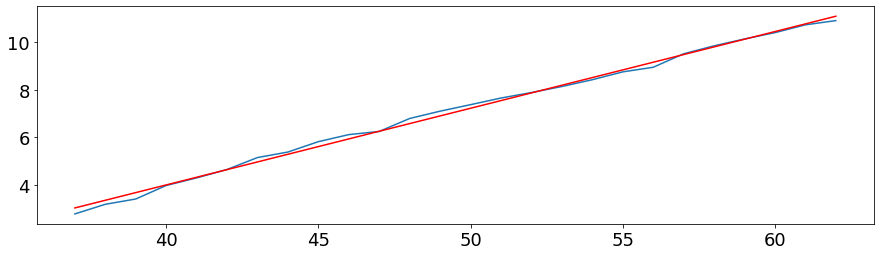

[[0.32306564]]


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

x = log_us_df.date_count.values.reshape(-1, 1)
y = log_us_df[country].values.reshape(-1, 1)
lin_reg = LinearRegression()
lin_reg.fit(x, y)
y_fit = lin_reg.predict(x)

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x, y_fit, color='red')
plt.show()
print(lin_reg.coef_)

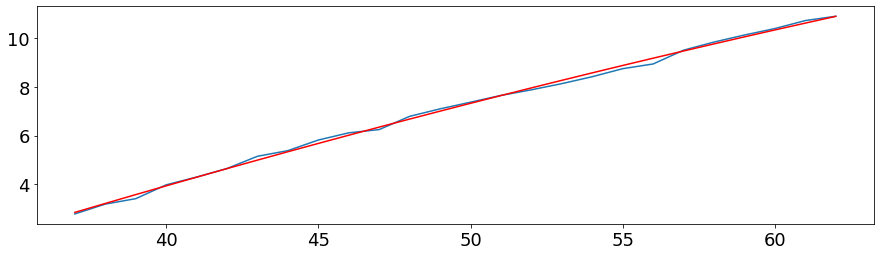

In [30]:
x = log_us_df.date_count.values.reshape(-1, 1)
x2 = x * x
y = log_us_df[country].values.reshape(-1, 1)
qua_reg = LinearRegression()
qua_reg.fit(np.c_[x, x2], y)
y_fit = qua_reg.predict(np.c_[x, x2])

plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.plot(x, y_fit, color='red')
plt.show()

In [31]:
regressor = qua_reg

x_fut = x.copy()
x_fut -= x.min()
x_fut += x.max()
if regressor == qua_reg:
    y_fut = regressor.predict(np.c_[x_fut, x_fut*x_fut])
else:
    y_fut = regressor.predict(x_fut)
print(y_fut)
y_fut = np.exp(y_fut)
mat = np.c_[x_fut, y_fut].astype(int)
print(mat)

[[10.91184833]
 [11.18572543]
 [11.4558188 ]
 [11.72212843]
 [11.98465433]
 [12.24339649]
 [12.49835492]
 [12.74952962]
 [12.99692058]
 [13.24052781]
 [13.4803513 ]
 [13.71639107]
 [13.94864709]
 [14.17711939]
 [14.40180795]
 [14.62271277]
 [14.83983386]
 [15.05317122]
 [15.26272484]
 [15.46849473]
 [15.67048089]
 [15.86868331]
 [16.063102  ]
 [16.25373695]
 [16.44058818]
 [16.62365566]]
[[      62    54822]
 [      63    72093]
 [      64    94449]
 [      65   123269]
 [      66   160276]
 [      67   207605]
 [      68   267896]
 [      69   344389]
 [      70   441053]
 [      71   562714]
 [      72   715224]
 [      73   905634]
 [      74  1142405]
 [      75  1435637]
 [      76  1797321]
 [      77  2241627]
 [      78  2785210]
 [      79  3447539]
 [      80  4251255]
 [      81  5222541]
 [      82  6391508]
 [      83  7792585]
 [      84  9464911]
 [      85 11452710]
 [      86 13805645]
 [      87 16579137]]
